In [3]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def load_data(rand_state=1234, test_size=0.2):
    
    cols = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
        'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
        'hours-per-week', 'native-country', 'income']
    df = pd.read_csv('../data/adult/adult.data', names=cols)
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

    sensitive_cols = ['age', 'race', 'sex']
    quant_cols = ['fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
    X = df[df.columns[:-1]]
    X[quant_cols] = (X[quant_cols] - X[quant_cols].mean()) / X[quant_cols].std()
    A = X[sensitive_cols]
    X = X.drop(sensitive_cols, axis=1)
    X = pd.get_dummies(X)
    A = pd.get_dummies(A)
        
    y = df['income']
    y = y.apply(lambda x: 1 if x.strip() == '>50K' else 0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state, stratify=y)
    
    A_train = A.loc[X_train.index]
    A_test = A.loc[X_test.index]
    
    return (X_train, y_train, A_train), (X_test, y_test, A_test)

In [5]:
(X_train, y_train, A_train), (X_test, y_test, A_test) = load_data()

//anaconda/envs/py35/lib/python3.5/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [6]:
y_train.groupby([A_train['sex_Male'], y_train]).count() / A_train['sex_Male'].groupby(A_train['sex_Male']).count()

sex_Male  income
0         0         0.891590
          1         0.108410
1         0         0.693943
          1         0.306057
dtype: float64

In [7]:
train_dataset = TensorDataset(
        torch.from_numpy(X_train.values).float(), 
        torch.from_numpy(y_train.values).float(),
        torch.from_numpy(A_train.values).float())
train_loader = DataLoader(
        train_dataset, batch_size=1024, shuffle=True)

In [8]:
in_dim = X_train.shape[1]
h_dim = 64
out_dim = 1

model = nn.Sequential(
    nn.Linear(in_dim, h_dim),
    nn.ReLU(),
    nn.Linear(h_dim, out_dim),
    nn.Sigmoid()
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
model

Sequential(
  (0): Linear(in_features=100, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Sigmoid()
)

In [10]:
for epoch in range(20):
    running_loss = 0.0
    total_correct = 0
    total_size = 0
    for i, data in enumerate(train_loader):
        inputs, labels, sens = data
        inputs, labels = Variable(inputs), Variable(labels.float())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs).squeeze()
        batch_size = outputs.shape[0]
        loss = criterion(outputs, labels)
        total_size += batch_size
        total_correct += torch.sum(outputs.round() == labels).item()
        loss.backward()
        optimizer.step()

        running_loss += loss.data.item() * batch_size
    # print statistics
    print('[%2d] loss: %.3f | acc: %.3f' % (epoch + 1, running_loss / total_size, total_correct / total_size))


[ 1] loss: 0.621 | acc: 0.773
[ 2] loss: 0.502 | acc: 0.793
[ 3] loss: 0.406 | acc: 0.825
[ 4] loss: 0.359 | acc: 0.839
[ 5] loss: 0.342 | acc: 0.844
[ 6] loss: 0.334 | acc: 0.847
[ 7] loss: 0.330 | acc: 0.848
[ 8] loss: 0.326 | acc: 0.850
[ 9] loss: 0.324 | acc: 0.851
[10] loss: 0.322 | acc: 0.852
[11] loss: 0.321 | acc: 0.852
[12] loss: 0.319 | acc: 0.852
[13] loss: 0.318 | acc: 0.853
[14] loss: 0.318 | acc: 0.853
[15] loss: 0.317 | acc: 0.852
[16] loss: 0.317 | acc: 0.853
[17] loss: 0.316 | acc: 0.853
[18] loss: 0.316 | acc: 0.854
[19] loss: 0.315 | acc: 0.853
[20] loss: 0.315 | acc: 0.854


In [11]:
inputs = torch.from_numpy(X_test.values).float()
outputs = model(inputs).squeeze().data.numpy()
y_pred = outputs.round()
np.mean(y_pred == y_test)

0.8493781667434362

In [12]:
female = (A_test['sex_Female'] == 1)
black = (A_test['race_Black'] == 1)
white = (A_test['race_White'] == 1)

In [13]:
y_pred[female].mean()

0.089696415

In [14]:
y_pred[~female].mean()

0.25351465

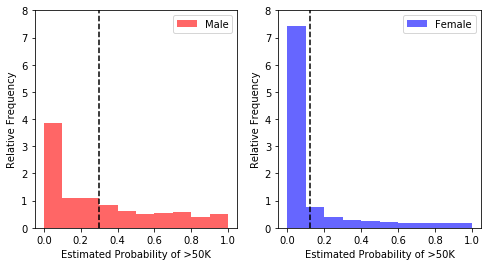

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4)) 
ax[0].hist(outputs[~female], normed=True, alpha=0.6, color='red')
ax[0].legend(['Male', 'Male Average'])
ax[0].set_ylim([0, 8])
ax[0].set_xlabel('Estimated Probability of >50K')
ax[0].axvline(outputs[~female].mean(), color='black', ls='--')
ax[0].set_ylabel('Relative Frequency')
ax[1].hist(outputs[female], normed=True, alpha=0.6, color='blue')
ax[1].legend(['Female', 'Female Average'])
ax[1].set_xlabel('Estimated Probability of >50K')
ax[1].set_ylim([0, 8])
ax[1].axvline(outputs[female].mean(), color='black', ls='--')
ax[1].set_ylabel('Relative Frequency')
#plt.savefig('vanilla-bias.pdf', bbox_inches='tight')

In [16]:
outputs[female].mean()

0.12484254

In [17]:
outputs[~female].mean()

0.29983118

In [18]:
outputs.shape

(6513,)

In [19]:
X_train.shape

(26048, 100)

## Sex

In [20]:
## Adapted this paper to work with neural nets: https://people.mpi-sws.org/~gummadi/papers/disparate_impact_AISTATS_2017.pdf

In [21]:
model2s = []
for reg in [3e-2, 1e-2, 3e-3, 1e-3, 3e-4, 1e-4]:
    
    print(reg)
    model2 = nn.Sequential(
        nn.Linear(in_dim, h_dim),
        nn.ReLU(),
        nn.Linear(h_dim, out_dim),
    )

    criterion2 = nn.BCELoss()
    optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)

    for epoch in range(20):
        running_loss = 0.0
        total_correct = 0
        total_size = 0
        for i, data in enumerate(train_loader):
            inputs, labels, sens = data
            inputs, labels, sens = Variable(inputs), Variable(labels.float()), Variable(sens)
            z = sens[:, -1]

            # zero the parameter gradients
            optimizer2.zero_grad()

            # forward + backward + optimize
            outputs = model2(inputs).squeeze()
            batch_size = outputs.shape[0]
            output_probs = torch.sigmoid(outputs)
            loss = criterion2(output_probs, labels) + reg * torch.abs(torch.sum((z - z.mean()) * outputs))
            total_size += batch_size
            total_correct += torch.sum(output_probs.round() == labels).item()
            loss.backward()
            optimizer2.step()

            running_loss += loss.data.item() * batch_size
        # print statistics
        # print('[%2d] loss: %.3f | acc: %.3f' % (epoch + 1, running_loss / total_size, total_correct / total_size))
        
    model2s.append(model2)


0.03
0.01
0.003
0.001
0.0003
0.0001


In [43]:
test_acc = []
train_acc = []
train_bce = []
test_p = []
train_p = []

for model2 in model2s:
    
    inputs = torch.from_numpy(X_test.values).float()
    output_probs = torch.sigmoid(model2(inputs)).squeeze().data.numpy()
    y_pred = output_probs.round()

    female = (A_test['sex_Female'] == 1)
    test_acc.append(np.mean(y_pred == y_test))
    p = output_probs[female].mean() / output_probs[~female].mean()
    if np.isnan(p):
        test_p.append(1)
    else:
        test_p.append(p)
    
    inputs = torch.from_numpy(X_train.values).float()
    output_probs = torch.sigmoid(model2(inputs)).squeeze().data.numpy()
    y_pred = output_probs.round()

    female = (A_train['sex_Female'] == 1)
    train_acc.append(np.mean(y_pred == y_train))
    p = output_probs[female].mean() / output_probs[~female].mean()
    if np.isnan(p):
        train_p.append(1)
    else:
        train_p.append(p)
    train_bce.append(-np.mean(y_train * np.log(output_probs) + (1 - y_train) * np.log(1 - output_probs)))


In [44]:
train_p

[0.9884493, 0.9793148, 0.95835483, 0.8607996, 0.76078933, 0.53057015]

In [45]:
test_p

[0.9926306, 0.9885101, 0.979356, 0.88831884, 0.7924642, 0.5498254]

In [46]:
test_p

[0.9926306, 0.9885101, 0.979356, 0.88831884, 0.7924642, 0.5498254]

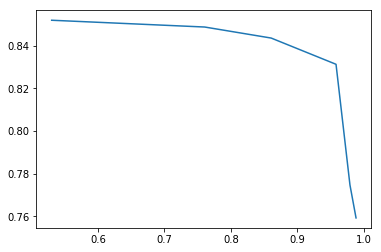

In [47]:
plt.plot(train_p, train_acc)

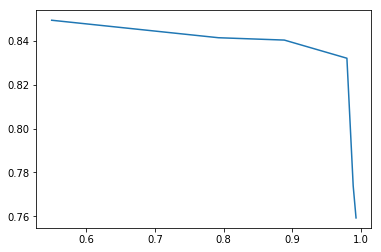

In [48]:
plt.plot(test_p, test_acc)

In [29]:
test_acc

[0.7592507293106096,
 0.7738369415016122,
 0.8321817902656226,
 0.8404729003531399,
 0.8415476738830032,
 0.849531705819131]

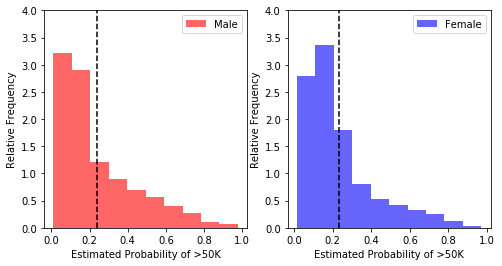

In [50]:
inputs = torch.from_numpy(X_test.values).float()
outputs = torch.sigmoid(model2s[2](inputs)).squeeze().data.numpy()
female = (A_test['sex_Female'] == 1)

fig, ax = plt.subplots(1, 2, figsize=(8, 4)) 
ax[0].hist(outputs[~female], normed=True, alpha=0.6, color='red')
ax[0].legend(['Male', 'Male Average'])
ax[0].set_ylim([0, 4])
ax[0].set_xlabel('Estimated Probability of >50K')
ax[0].axvline(outputs[~female].mean(), color='black', ls='--')
ax[0].set_ylabel('Relative Frequency')
ax[1].hist(outputs[female], normed=True, alpha=0.6, color='blue')
ax[1].legend(['Female', 'Female Average'])
ax[1].set_xlabel('Estimated Probability of >50K')
ax[1].set_ylim([0, 4])
ax[1].axvline(outputs[female].mean(), color='black', ls='--')
ax[1].set_ylabel('Relative Frequency')
#plt.savefig('vanilla-bias.pdf', bbox_inches='tight')

In [487]:
inputs = torch.from_numpy(X_train.values).float()
output_probs = torch.sigmoid(model2(inputs)).squeeze().data.numpy()
y_pred = output_probs.round()
np.mean(y_pred == y_train)

female = (A_train['sex_Female'] == 1)
print(y_pred[female].mean())
print(y_pred[~female].mean())

0.11538909
0.1664661


In [ ]:
female = (A_test['sex_Female'] == 1)
black = (A_test['race_Black'] == 1)
white = (A_test['race_White'] == 1)

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6201: RuntimeWarning: invalid value encountered in true_divide
  m = (m.astype(float) / db) / m.sum()


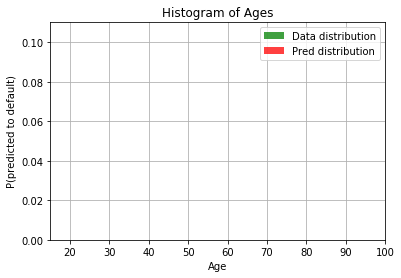

In [298]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(all_ages, 40, normed=1, facecolor='green', alpha=0.75, label='Data distribution')
n, bins, patches = plt.hist(pred_ages, 40, normed=1, facecolor='red', alpha=0.75, label='Pred distribution')

plt.xlabel('Age')
plt.ylabel('P(predicted to default)')
plt.title('Histogram of Ages')
plt.grid(True)
plt.axis([15, 100, 0, 0.11])
plt.legend()
plt.show()

In [95]:
with open('../results/preds.txt', "w") as fout:
    print("Id,Probability", file=fout)
    for i, data in enumerate(test_loader, start=1):
        input, _ = data
        input = Variable(input)

        output = model(input).squeeze()
        print("%d,%f"%(i, output), file=fout)